# Price recommendation for Online Marketplace

GOAL of this project: 
Predict Reasonable pricing for marketplace sellers of Mercari by using XGBoost 

Possible Application:


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats
import datetime as dt
%matplotlib inline

In [3]:
train = pd.read_csv('/Users/asamitakeuchi/mercari/train.tsv', sep='\t')
test = pd.read_csv('/Users/asamitakeuchi/mercari/test.tsv', sep='\t')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
#check null data
def check_if_null(df):
    null = df.isnull().sum()
    null_percent = (df.isnull().sum()/df.count()*100).round(2)
    null_values = pd.concat([null, null_percent], axis = 1)
    null_values.columns = ['Null Values', '%Null']
    return null_values

check_if_null(train)

,Null Values,%Null
train_id,0,0.00
name,0,0.00
item_condition_id,0,0.00
category_name,6327,0.43
brand_name,632682,74.45
price,0,0.00
shipping,0,0.00
item_description,4,0.00


In [7]:
train['category_name'].value_counts()[:20]

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Women/Dresses/Above Knee, Mini                                 20082
Women/Jewelry/Necklaces                                        19758
Women/Athletic Apparel/Shorts                                  19528
Beauty/Makeup/Makeup Palettes                                  19103
Women/Shoes/Boots                 

The "category name" column is separated into three categories by using "/".
Let's separate them into three columns.

In [8]:
#make a function to separate the columns
train[["cat_1","cat_2","cat_3"]] = train.category_name.str.split("/", n=2, expand=True)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [9]:
#Check each category
train.cat_1.value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Name: cat_1, dtype: int64

In [10]:
train.cat_2.value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_2, Length: 113, dtype: int64

In [11]:
train.cat_2.unique()

array(['Tops', 'Computers & Tablets', 'Tops & Blouses', 'Home Décor',
       'Jewelry', 'Other', 'Swimwear', 'Apparel', 'Collectibles',
       'Makeup', 'Fragrance', 'Dresses', 'Office supplies', 'Shoes',
       'Gear', 'Athletic Apparel', 'Cell Phones & Accessories', 'Jeans',
       'Underwear', 'Skin Care', 'Toys', "Women's Handbags",
       'Video Games & Consoles', 'Coats & Jackets', 'Pants', 'Girls (4+)',
       'Antique', 'Kitchen & Dining', 'Sweaters', 'Boys 0-24 Mos',
       'Girls 0-24 Mos', 'Maternity', 'Bedding', 'Exercise',
       'Trading Cards', 'Boys (4+)', 'Storage & Organization', 'Fan Shop',
       'Girls 2T-5T', "Men's Accessories", 'Boys 2T-5T',
       "Women's Accessories", 'Daily & Travel items', nan, 'Skirts',
       'Hair Care', 'Pet Supplies', 'Book', 'Tools & Accessories',
       'Team Sports', 'Home Appliances', 'Accessories', 'Bags and Purses',
       'Sweats & Hoodies', 'Shorts', 'TV, Audio & Surveillance',
       'Outdoors', 'Bath & Body', 'Car Seats & Acc

In [12]:
train.cat_3.value_counts()

Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         32168
                              ...  
Storage Solutions                 1
Map                               1
International Publications        1
St Patricks                       1
Ephemera                          1
Name: cat_3, Length: 871, dtype: int64

In [13]:
#There are 4809 different brands
train.groupby('brand_name').size()

brand_name
!iT Jeans              1
% Pure                61
10.Deep                3
191 Unlimited          1
1byone                 1
                    ... 
tokidoki             310
totes ISOTONER        28
triangl swimwear       5
vineyard vines      1712
wallis                 1
Length: 4809, dtype: int64

In [14]:
train["brand_name"].isnull().sum()

632682

In [15]:
#Fill Null values of brand_name with "Nobrand"
train["brand_name"] = train["brand_name"].fillna("NoBrand")
train["brand_name"].head()

0    NoBrand
1      Razer
2     Target
3    NoBrand
4    NoBrand
Name: brand_name, dtype: object

In [16]:
train.to_csv("train2.csv"
            , header=True
            , index=False
            , chunksize=1500000
            , encoding="utf-8")

In [17]:
#Checking the prices
train.groupby('price').size().sort_values(ascending=False)

price
10.0      99416
12.0      78986
14.0      76655
16.0      66413
9.0       63643
          ...  
727.0         1
744.0         1
745.0         1
749.0         1
2009.0        1
Length: 828, dtype: int64

In [18]:
train["price"].value_counts()[:20]

10.0    99416
12.0    78986
14.0    76655
16.0    66413
9.0     63643
8.0     61564
15.0    58082
20.0    56323
Name: price, dtype: int64

In [19]:
train["price"].value_counts()[:20]

10.0    99416
12.0    78986
14.0    76655
16.0    66413
9.0     63643
8.0     61564
15.0    58082
20.0    56323
Name: price, dtype: int64

# Data Exploration and Data Visualization 

<Axes: xlabel='price', ylabel='Count'>

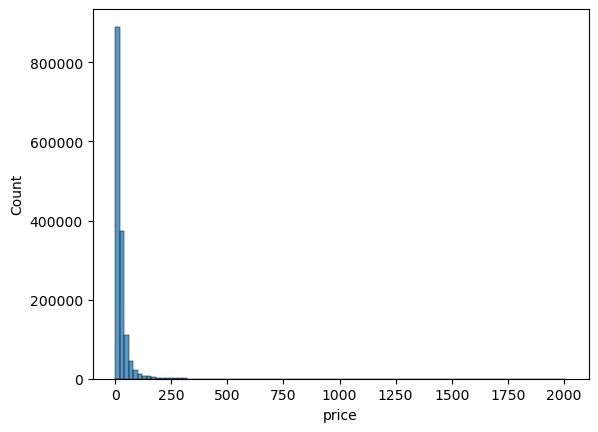

In [20]:
#Price distribution
sns.histplot(train["price"], bins=100)

/Users/asamitakeuchi/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='price', ylabel='Count'>

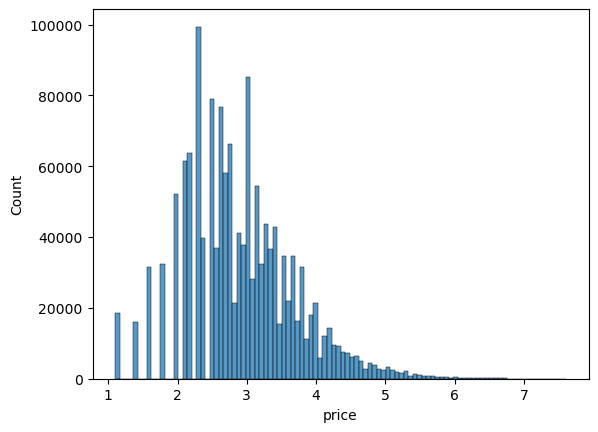

In [21]:
#The distribution of price is skewed
#Perform log transformation

log_price = np.log(train["price"])
sns.histplot(log_price, bins=100)

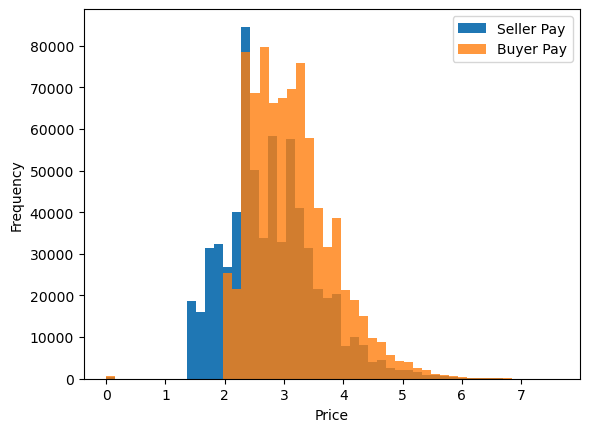

In [22]:
#distribution of price by shipping methods
#1=shipping fee paid by sellers & 0=by buyers

seller_pay = train.loc[train["shipping"] == 1, "price"]
buyer_pay = train.loc[train["shipping"] == 0, "price"]

plt.hist(np.log(seller_pay+1), bins=50, alpha=1, label="Seller Pay")
plt.hist(np.log(buyer_pay+1), bins=50, alpha= 0.8, label="Buyer Pay")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The product tend to have higher price when buyers pay the shipment fees.

<Axes: xlabel='item_condition_id', ylabel='price'>

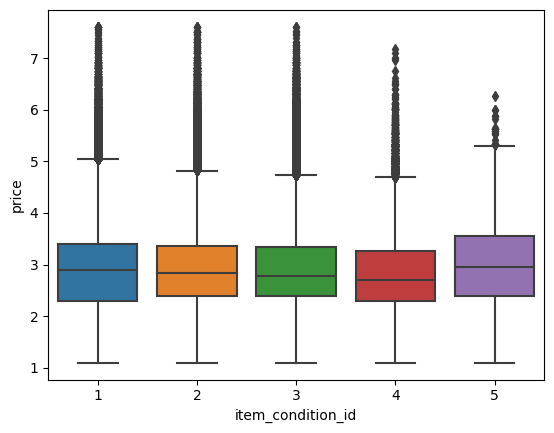

In [23]:
#Distribution of price by item_condition_id
sns.boxplot(train, x=train["item_condition_id"], y=log_price)

In [42]:
train.groupby('item_condition_id').price.agg(["mean","min","max","median","count"]).sort_values(by="mean", ascending=False)

,mean,min,max,median,count
item_condition_id,,,,,
5,31.703859,0.0,522.0,19.0,2384
2,27.563225,0.0,2004.0,17.0,375479
3,26.540711,0.0,2000.0,16.0,432161
1,26.486967,0.0,2009.0,18.0,640549
4,24.349212,0.0,1309.0,15.0,31962


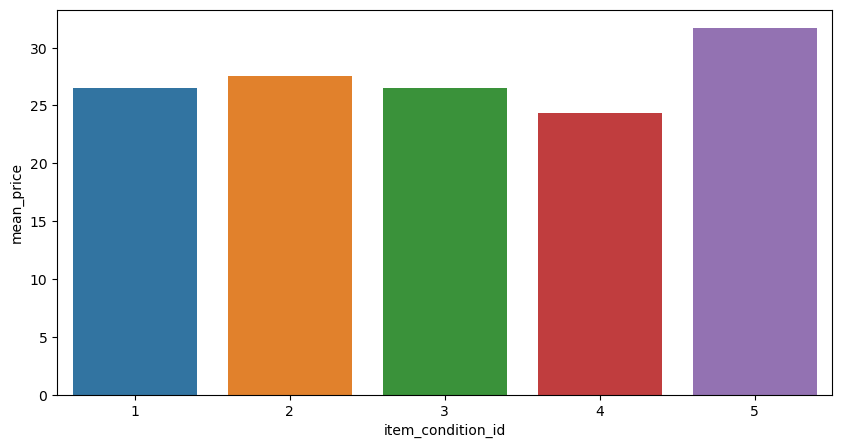

In [41]:
conditions = train.groupby('item_condition_id').price.mean().reset_index(name='mean_price').sort_values(by="mean_price", ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
_=sns.barplot(data=conditions, x="item_condition_id", y="mean_price")

It seems tha variance by each condition are fine.

In [24]:
#Exploration & Visualizations by brand names
#Top 20 brands
train.groupby("brand_name").price.agg(["count","mean","min","max","median"]).sort_values(by="count", ascending=False)[:20]

,count,mean,min,max,median
brand_name,,,,,
NoBrand,632682,21.133453,0.0,2000.0,14.0
PINK,54088,26.341314,0.0,798.0,20.0
Nike,54043,30.760265,0.0,459.0,22.0
Victoria's Secret,48036,23.214287,0.0,1400.0,19.0
LuLaRoe,31024,33.667967,0.0,350.0,29.0
Apple,17322,73.268618,0.0,1909.0,22.0
FOREVER 21,15186,12.929935,0.0,180.0,12.0
Nintendo,15007,34.672619,0.0,600.0,20.0
Lululemon,14558,47.096717,0.0,711.0,39.0


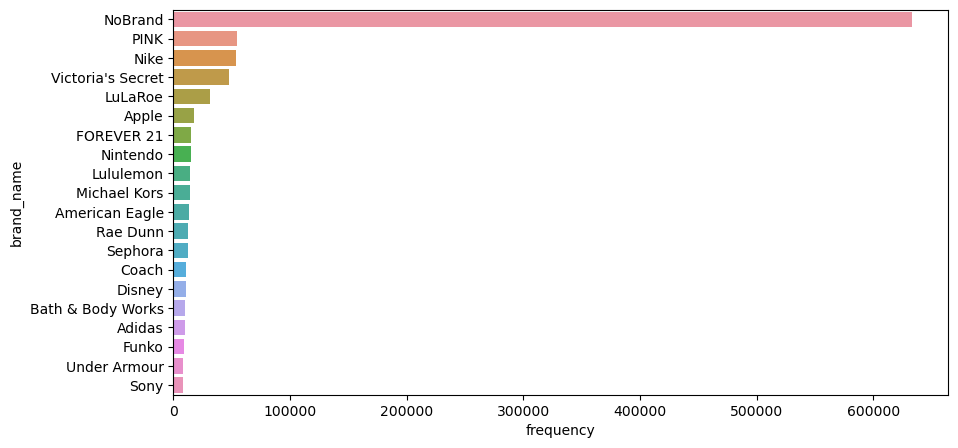

In [25]:
#Visualization
top20_brands = train.groupby("brand_name").size().reset_index(name="frequency").sort_values("frequency", ascending=False).reset_index()[:20]
fig, ax = plt.subplots(figsize=(10,5))
_=sns.barplot(x="frequency", y="brand_name", data=top20_brands)


In [26]:
#Mean, min, max, and media prices by top 20 brands (sorted by mean prices)
train.groupby("brand_name").price.agg(["mean","min","max","median","count"]).sort_values(by="mean", ascending=False)[:20]

,mean,min,max,median,count
brand_name,,,,,
Demdaco,429.000000,10.0,848.0,429.0,2
Proenza Schouler,413.250000,16.0,1006.0,315.5,4
Auto Meter,344.000000,344.0,344.0,344.0,1
Oris,300.000000,300.0,300.0,300.0,1
MCM Worldwide,289.173913,11.0,1359.0,129.0,69
Longines,254.000000,254.0,254.0,254.0,1
Vitamix,253.111111,16.0,640.0,205.0,9
Blendtec,251.800000,134.0,415.0,250.0,5
David Yurman,248.611570,7.0,2004.0,220.0,242


Interestingly, the top 20 highest mean prices are pretty different from the top 10 listed brands

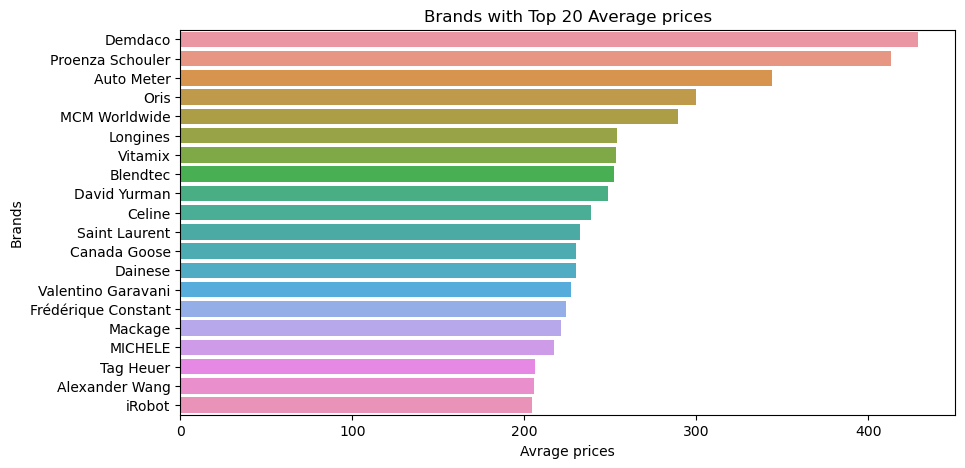

In [27]:
top20_price_br = train.groupby("brand_name").price.mean().reset_index(name="mean_price").sort_values(by="mean_price", ascending=False)[:20]
fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(x="mean_price", y="brand_name", data=top20_price_br)
_ = ax.set(title="Brands with Top 20 Average prices", xlabel="Avrage prices", ylabel="Brands")

In [28]:
train["brand_name"].unique()

array(['NoBrand', 'Razer', 'Target', ..., 'Astroglide', 'Cumberland Bay',
       'Kids Only'], dtype=object)

In [29]:
#size, min/max/mean/median prices of category 1
train.groupby("cat_1").price.agg(["size","min","max","mean","median"]).sort_values(by="size", ascending=False)

,size,min,max,mean,median
cat_1,,,,,
Women,664385,0.0,2009.0,28.885496,19.0
Beauty,207828,0.0,2000.0,19.671536,15.0
Kids,171689,0.0,809.0,20.642315,14.0
Electronics,122690,0.0,1909.0,35.173922,15.0
Men,93680,0.0,1309.0,34.708614,21.0
Home,67871,0.0,848.0,24.536599,18.0
Vintage & Collectibles,46530,0.0,1709.0,27.339426,16.0
Other,45351,0.0,1400.0,20.809817,14.0
Handmade,30842,0.0,1750.0,18.156572,12.0


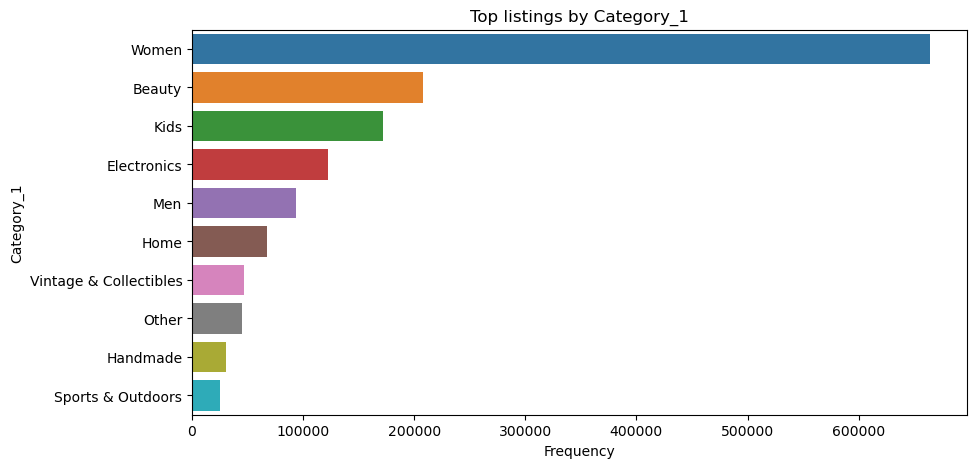

In [32]:
#Visualization of ranks by numbers of listing by category 1
cat_1_rank = train.groupby("cat_1").price.count().reset_index(name="frequency").sort_values(by="frequency", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_1_rank, x="frequency", y="cat_1")
_ = ax.set(title="Top listings by Category_1", xlabel="Frequency", ylabel="Category_1")

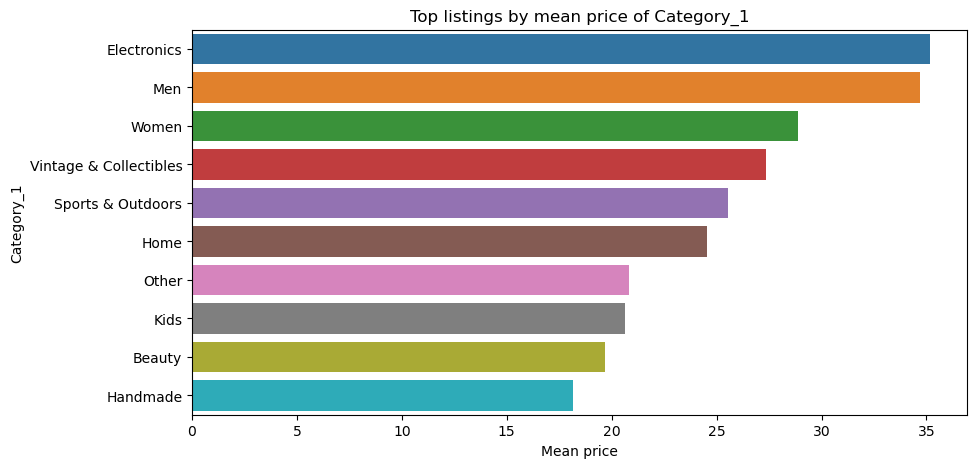

In [35]:
cat_1_mean = train.groupby("cat_1").price.mean().reset_index(name="mean_price").sort_values(by="mean_price", ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_1_mean, x="mean_price", y="cat_1")
_ = ax.set(title="Top listings by mean price of Category_1", xlabel="Mean price", ylabel="Category_1")

Compared to the rnaking by the number of listings, Electronics and Men categories have higher mean prices among the listings. Vintage & Collectibles, Sports & Outdoors, and Home categories also have fewer numebr of listings but average prices are relatively higher. In contrast, Beauty and kids categories have higher numebr of listings but their abarage risting prices tend to be lower.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Men'),
  Text(1, 0, 'Electronics'),
  Text(2, 0, 'Women'),
  Text(3, 0, 'Home'),
  Text(4, 0, 'Sports & Outdoors'),
  Text(5, 0, 'Vintage & Collectibles'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Kids'),
  Text(9, 0, 'Handmade')])

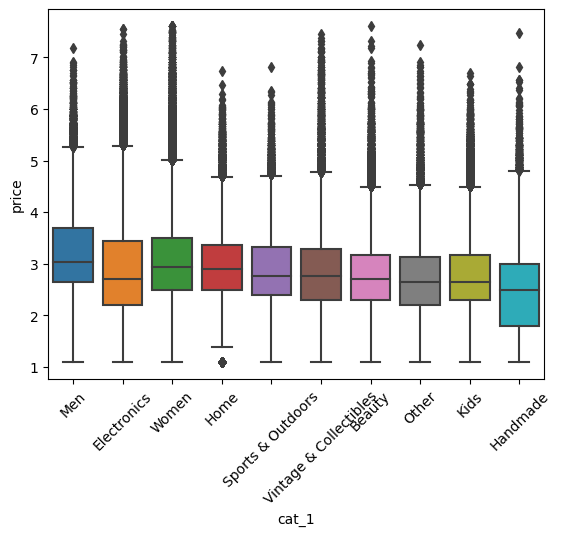

In [34]:
sns.boxplot(train, x=train["cat_1"], y=log_price)
plt.xticks(rotation=45)

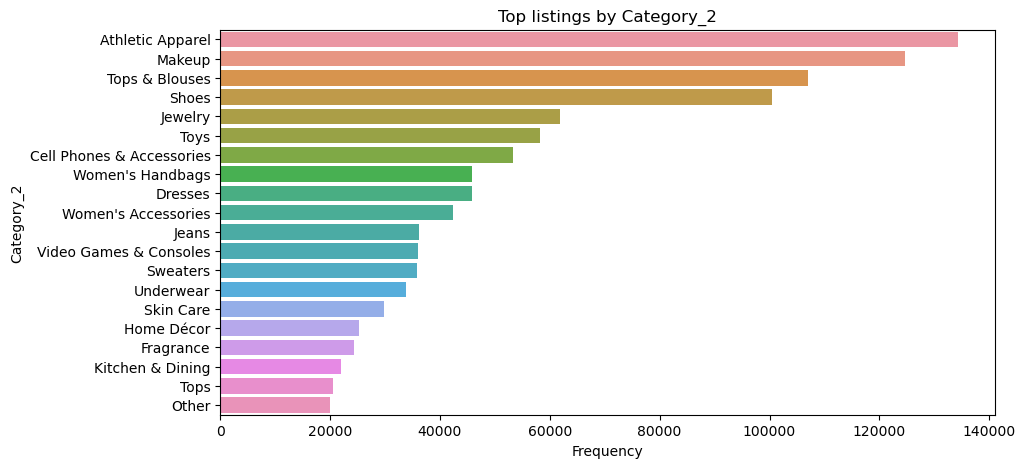

In [38]:
#Visualization of ranks by numbers of listing by category 2
cat_2_rank = train.groupby("cat_2").price.count().reset_index(name="frequency").sort_values(by="frequency", ascending=False)[:20]

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_2_rank, x="frequency", y="cat_2")
_ = ax.set(title="Top listings by Category_2", xlabel="Frequency", ylabel="Category_2")

In [43]:
#size, min/max/mean/median prices of category 2
train.groupby('cat_2').price.agg(["size","min","max","mean","median"]).sort_values(by="size", ascending=False)

,size,min,max,mean,median
cat_2,,,,,
Athletic Apparel,134383,0.0,855.0,28.460940,22.0
Makeup,124624,0.0,2000.0,18.686176,15.0
Tops & Blouses,106960,0.0,1525.0,18.237514,14.0
Shoes,100452,0.0,950.0,41.811223,29.0
Jewelry,61763,0.0,2004.0,27.501571,14.0
...,...,...,...,...,...
Candles,64,3.0,95.0,21.734375,16.0
Ceramics and Pottery,57,3.0,66.0,20.280702,15.0
Dolls and Miniatures,49,5.0,129.0,27.469388,15.0


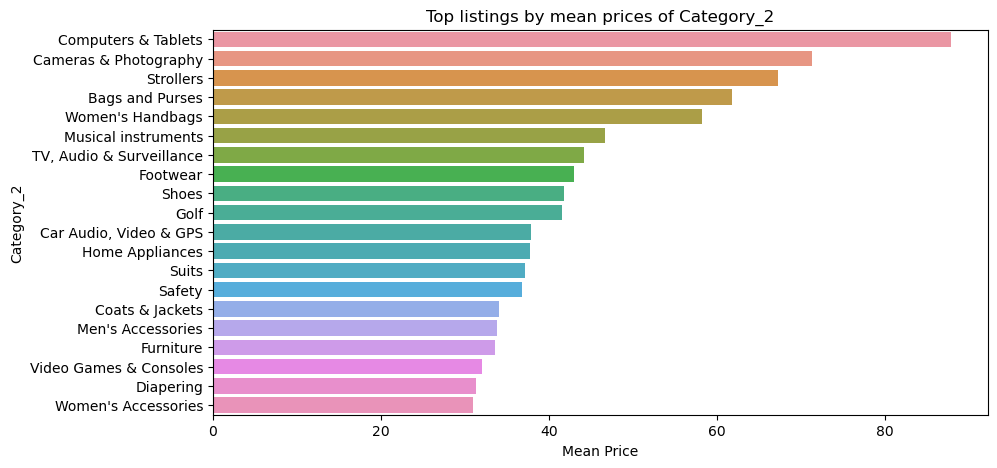

In [44]:
#Visualization of ranks by mean prices by category 2
cat_2_mean = train.groupby("cat_2").price.mean().reset_index(name="mean_price").sort_values(by="mean_price", ascending=False)[:20]

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_2_mean, x="mean_price", y="cat_2")
_ = ax.set(title="Top listings by mean prices of Category_2", xlabel="Mean Price", ylabel="Category_2")

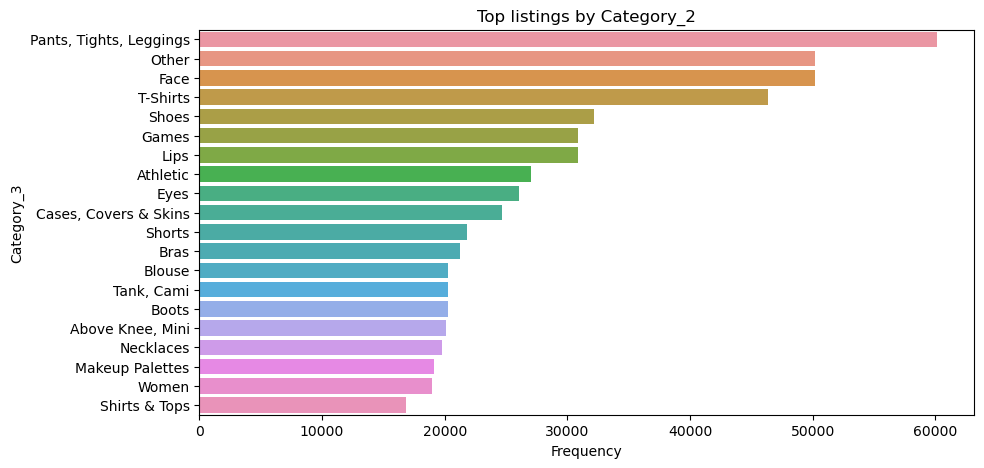

In [45]:
#Visualization of ranks by numbers of listing by category 3
cat_3_rank = train.groupby("cat_3").price.count().reset_index(name="frequency").sort_values(by="frequency", ascending=False)[:20]

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_3_rank, x="frequency", y="cat_3")
_ = ax.set(title="Top listings by Category_2", xlabel="Frequency", ylabel="Category_3")

In [46]:
#size, min/max/mean/median prices of category 3
train.groupby('cat_3').price.agg(["size","min","max","mean","median"]).sort_values(by="size", ascending=False)

,size,min,max,mean,median
cat_3,,,,,
"Pants, Tights, Leggings",60177,0.0,600.0,34.392733,29.0
Other,50224,0.0,1400.0,23.694827,16.0
Face,50171,0.0,2000.0,19.737039,15.0
T-Shirts,46380,0.0,1525.0,19.386125,15.0
Shoes,32168,0.0,366.0,24.794656,18.0
...,...,...,...,...,...
Bathroom,1,39.0,39.0,39.000000,39.0
Four Button,1,20.0,20.0,20.000000,20.0
Aceo,1,12.0,12.0,12.000000,12.0


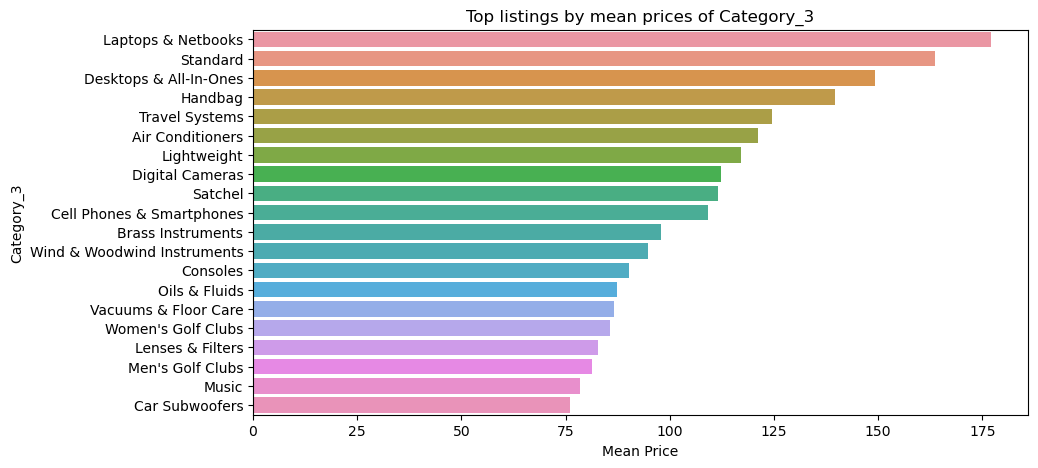

In [47]:
#Visualization of ranks by mean prices by category 2
cat_3_mean = train.groupby("cat_3").price.mean().reset_index(name="mean_price").sort_values(by="mean_price", ascending=False)[:20]

fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(data=cat_3_mean, x="mean_price", y="cat_3")
_ = ax.set(title="Top listings by mean prices of Category_3", xlabel="Mean Price", ylabel="Category_3")